In [ ]:
!pip install transformers
!pip install easydict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 5.2 MB/s 
     |████████████████████████████████| 163 kB 75.9 MB/s 
     |████████████████████████████████| 7.6 MB 84.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%cd /content/drive/MyDrive/CDT-final

/content/drive/MyDrive/CDT-final


In [ ]:
!ls

data  results  wandb


In [ ]:
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 5.1 MB/s 
     |████████████████████████████████| 182 kB 66.2 MB/s 
     |████████████████████████████████| 162 kB 68.6 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 162 kB 68.8 MB/s 
     |████████████████████████████████| 158 kB 82.6 MB/s 
     |████████████████████████████████| 157 kB 86.8 MB/s 
     |████████████████████████████████| 157 kB 78.1 MB/s 
     |████████████████████████████████| 157 kB 68.7 MB/s 
     |████████████████████████████████| 157 kB 68.1 MB/s 
     |████████████████████████████████| 157 kB 69.9 MB/s 
     |████████████████████████████████| 157 kB 83.5 MB/s 
     |████████████████████████████████| 157 kB 90.3 MB/s 
     |████████████████████████████████| 156 kB 85.4 MB/s 


In [ ]:
# Log in to your W&B account
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import os
import random
import time
import datetime
import torch
import argparse
from glob import glob

from tqdm import tqdm
from easydict import EasyDict
import pandas as pd
import numpy as np
from fastprogress.fastprogress import master_bar, progress_bar

from keras_preprocessing.sequence import pad_sequences
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

In [ ]:
args = EasyDict({'raw_data': './data/Unsmile/Unsmile_train.tsv',
                 'domain' : 'Unsmile',
                 'testing_domain' : './data/HateScore/HateScore_train.tsv',
                 'test' : 'HateScore',
                 'max_len' : 128,
                 'batch_size' : 64,
                 'epochs' : 10,
                 'lr' : 5e-5,
                 'weight_decay' : 0.5,
                 'seed_val': 42,
                 'waiting' : 0,
                 'patient' : 3,
                 'weights_clean' : 0,
                 'weights_hate' : 0 
})

In [ ]:
def load_data(args, mode = None):
    if mode == None:
      temp = pd.read_csv(args.raw_data, sep='\t')
    else:
      temp = pd.read_csv(args.testing_domain, sep='\t')
      print("Test with : ", args.test)
    document = temp['comment'].tolist()
    labels = temp['hate'].tolist()
    return document, labels

def add_special_token(document):
    added = ["[CLS]" + str(sentence) + "[SEP]" for sentence in document]
    return added

def tokenization(document, mode="huggingface"):
    if mode == "huggingface":
        tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base")
    else:
        tokenizer = BertTokenizer.from_pretrained(
                'bert-base-multilingual-cased', 
                do_lower_case=False,
                )
    tokenized = [tokenizer.tokenize(sentence) for sentence in document]
    ids = [tokenizer.convert_tokens_to_ids(sentence) for sentence in tokenized]
    return ids

def padding(ids, args):
    ids = pad_sequences(ids, maxlen=args.max_len, dtype="long", truncating='post', padding='post')
    return ids

def attention_mask(ids):
    masks = []
    for id in ids:
        mask = [float(i>0) for i in id]
        masks.append(mask)
    return masks

def preprocess(args, mode = None):
    document, labels = load_data(args, mode)
    document = add_special_token(document)
    ids = tokenization(document)
    ids = padding(ids, args)
    masks = attention_mask(ids)
    del document
    return ids, masks, labels

def train_test_data_split(ids, masks, labels):
    train_ids, test_ids, train_labels, test_labels = train_test_split(ids, labels, random_state=42, test_size=0.3)
    train_masks, test_masks, _, _ = train_test_split(masks, ids, random_state=42, test_size=0.3)
    return train_ids, train_masks, train_labels, test_ids, test_masks, test_labels

def build_dataloader(ids, masks, label, args, mode = None):
    dataloader = TensorDataset(torch.tensor(ids), torch.tensor(masks), torch.tensor(label))
    if mode == 'train':
      class_counts = [label.count(0), label.count(1)]
      num_samples = sum(class_counts) 

      class_weights = [num_samples / class_counts[i] for i in range(len(class_counts))] 

      weights = [class_weights[label[i]] for i in range(int(num_samples))] 
      WRsampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))
      print(f"class_weights for 0 : {class_weights[0]}")
      print(f"class_weights for 1 : {class_weights[1]}")
      
      args.weights_clean = class_weights[0]
      args.weights_hate = class_weights[1]

      dataloader = DataLoader(dataloader, sampler = WRsampler, batch_size=args.batch_size)
    elif mode == 'inference':
      dataloader = DataLoader(dataloader, sampler = SequentialSampler(dataloader), batch_size=args.batch_size)
    else:
      dataloader = DataLoader(dataloader, sampler = RandomSampler(dataloader), batch_size=args.batch_size)
    return dataloader
        
def build_model(args):
    model = AutoModelForSequenceClassification.from_pretrained("beomi/KcELECTRA-base")
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"{torch.cuda.get_device_name(0)} available")
        model = model.cuda()
    else:
        device = torch.device("cpu")
        print("no GPU available")
        model = model
    return model, device

def test(test_dataloader, model, device):
    model.eval()
    total_loss, total_accuracy, total_f1 = 0, 0, 0
    for batch in tqdm(test_dataloader):
        batch = tuple(index.to(device) for index in batch)
        ids, masks, labels = batch
        with torch.no_grad():
            outputs = model(ids, token_type_ids=None, attention_mask=masks, labels=labels)
        pred = [torch.argmax(logit).cpu().detach().item() for logit in outputs.logits]
        true = [label for label in labels.cpu().numpy()]
        
        loss = outputs.loss
        total_loss += loss.item()
        
        accuracy = accuracy_score(true, pred)
        f1 = f1_score(true, pred)

        total_accuracy += accuracy
        total_f1 += f1
    
    avg_val_loss = total_loss / len(test_dataloader)
    avg_accuracy = total_accuracy/len(test_dataloader)
    avg_f1 = total_f1/len(test_dataloader)
    
    print(f"Epoch Average val loss :  {avg_val_loss}")
    print(f"Epoch Average val accuracy : {avg_accuracy: .2f}")
    print(f"Epoch Average val f1 : {avg_f1: .2f}")

    return avg_val_loss, avg_accuracy, avg_f1

def train(train_dataloader, test_dataloader, args):

    model, device = build_model(args)
    optimizer = AdamW(model.parameters(), lr = args.lr, eps=1e-8, weight_decay=args.weight_decay)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*args.epochs)
    random.seed(args.seed_val)
    np.random.seed(args.seed_val)
    torch.manual_seed(args.seed_val)
    torch.cuda.manual_seed_all(args.seed_val)
    model.zero_grad()

    es = [] # val_losses for early stopping
    
    for epoch in range(0, args.epochs):
        model.train()
        total_loss, total_accuracy, total_f1 = 0, 0, 0
        print("-"*30)
        print(f"Epoch : {epoch+1} in {args.epochs}")
        for step, batch in enumerate(
            tqdm(train_dataloader,
                desc=' - (Training)  ',
                leave=False,
                mininterval=1)):
            batch = tuple(index.to(device) for index in batch)
            ids, masks, labels, = batch

            outputs = model(ids, token_type_ids=None, attention_mask=masks, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            pred = [torch.argmax(logit).cpu().detach().item() for logit in outputs.logits]
            true = [label for label in labels.cpu().numpy()]
            
            accuracy = accuracy_score(true, pred)
            f1 = f1_score(true, pred)
            
            total_accuracy += accuracy
            total_f1 += f1

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            model.zero_grad()
        
        avg_loss = total_loss / len(train_dataloader)
        avg_accuracy = total_accuracy/len(train_dataloader)
        avg_f1 = total_f1/len(train_dataloader)

        print(f"Epoch Average train loss :  {avg_loss}")
        print(f"Epoch Average train accuracy :  {avg_accuracy: .2f}")
        print(f"Epoch Average train f1 score :  {avg_f1: .2f}")
        

        avg_val_loss, acc, f_score = test(test_dataloader, model, device)
        es.append(avg_val_loss)
        
        metrics = {
                  "train/loss": avg_loss, 
                  "train/accuracy": avg_accuracy,
                  "train/f1 score": avg_f1
                  }
        val_metrics = {
                  "val/loss": avg_val_loss, 
                  "val/accuracy": acc,
                  "val/f1 score": f_score
                  }

        wandb.log({**metrics, **val_metrics})


        args.waiting += 1

        if es[-1] <= min(es):
            args.waiting = 0
            ckpt_path = "./results/" + args.domain + '/ckpt'
            os.makedirs(ckpt_path, exist_ok=True)
            f = os.path.join(ckpt_path, 
                            f'evalF1_{f_score*100:.0f}_evalAcc_{acc*100:.0f}_epoch_{epoch+1}_{args.lr}_{args.weight_decay}.ckpt')
            torch.save(model.state_dict(), f)
            print('\t[!] The best checkpoint is updated.')
        
        if args.waiting > args.patient:
          print('\t[!] Early Stop')
          break   
    #wandb.finish()

In [ ]:
def make_inputs(args):
    ids, masks, labels = preprocess(args)
    train_ids, train_masks, train_labels, test_ids, test_masks, test_labels = train_test_data_split(ids, masks, labels)
    train_dataloader = build_dataloader(train_ids, train_masks, train_labels, args, mode = 'train')
    test_dataloader = build_dataloader(test_ids, test_masks, test_labels, args)
    
    return train_dataloader, test_dataloader

In [ ]:
train_dataloader, test_dataloader = make_inputs(args)

class_weights for 0 : 2.2385581206966383
class_weights for 1 : 1.8073904512753434


In [ ]:
wandb.init(
      # Set the project where this run will be logged
      project="Cross dataset testing", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"Training_{args.domain}", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": args.lr,
      "weight_decay" : args.weight_decay,
      "architecture": "KcELECTRA-base",
      "batch_size": args.batch_size,
      "epochs": args.epochs,
      "weights_clean" : args.weights_clean,
      "weights_hate" : args.weights_hate
      })

In [ ]:
train(train_dataloader, test_dataloader, args)

Some weights of the model checkpoint at beomi/KcELECTRA-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.weight', 'classifier.

A100-SXM4-40GB available
------------------------------
Epoch : 1 in 10


Epoch Average train loss :  0.4252134249813255
Epoch Average train accuracy :   0.79
Epoch Average train f1 score :   0.76


 97%|█████████▋| 37/38 [00:03<00:00,  9.54it/s]/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
100%|██████████| 38/38 [00:03<00:00,  9.72it/s]


Epoch Average val loss :  0.4738092218574725
Epoch Average val accuracy :  0.79
Epoch Average val f1 :  0.80
	[!] The best checkpoint is updated.
------------------------------
Epoch : 2 in 10


Epoch Average train loss :  0.24220527511561055
Epoch Average train accuracy :   0.91
Epoch Average train f1 score :   0.91


 97%|█████████▋| 37/38 [00:03<00:00,  9.54it/s]/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
100%|██████████| 38/38 [00:03<00:00,  9.75it/s]


Epoch Average val loss :  0.5015455279499292
Epoch Average val accuracy :  0.79
Epoch Average val f1 :  0.80
------------------------------
Epoch : 3 in 10


Epoch Average train loss :  0.15698193837942062
Epoch Average train accuracy :   0.95
Epoch Average train f1 score :   0.95


 97%|█████████▋| 37/38 [00:03<00:00,  9.54it/s]/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
100%|██████████| 38/38 [00:03<00:00,  9.75it/s]


Epoch Average val loss :  0.5574892314248964
Epoch Average val accuracy :  0.80
Epoch Average val f1 :  0.80
------------------------------
Epoch : 4 in 10


Epoch Average train loss :  0.1217587453302467
Epoch Average train accuracy :   0.96
Epoch Average train f1 score :   0.96


100%|██████████| 38/38 [00:03<00:00,  9.71it/s]


Epoch Average val loss :  0.6857965873358282
Epoch Average val accuracy :  0.80
Epoch Average val f1 :  0.81
------------------------------
Epoch : 5 in 10


Epoch Average train loss :  0.07284578325590868
Epoch Average train accuracy :   0.98
Epoch Average train f1 score :   0.98


 97%|█████████▋| 37/38 [00:03<00:00,  9.53it/s]/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
100%|██████████| 38/38 [00:03<00:00,  9.73it/s]

Epoch Average val loss :  0.8542954327146474
Epoch Average val accuracy :  0.80
Epoch Average val f1 :  0.80
	[!] Early Stop


train/accuracy,▁▅▇▇█
train/f1 score,▁▆▇▇█
train/loss,█▄▃▂▁
val/accuracy,▁▂▆▄█
val/f1 score,▄▃▁█▅
val/loss,▁▂▃▅█
train/accuracy,0.98024
train/f1 score,0.98013
train/loss,0.07285
val/accuracy,0.80469
val/f1 score,0.80429


***

In [ ]:
ckpt_path = "./results/" + args.domain + '/ckpt'
latest_ckpt = sorted(glob(ckpt_path + '/*.ckpt'))[-1]
#latest_ckpt = './results/Beep/ckpt/epoch_2_evalAcc_81_evalF1_81.ckpt'
checkpoint = torch.load(latest_ckpt)
print(latest_ckpt)

./results/Unsmile/ckpt/epoch_2_evalAcc_89_evalF1_92.ckpt


In [ ]:
def inference_try(inference_dataloader, model, device):
    pred_sum = []
    proba_sum = []
    true_sum = []

    model.eval()
    total_loss, total_accuracy, total_f1 = 0, 0, 0
    for batch in progress_bar(inference_dataloader):

        batch = tuple(index.to(device) for index in batch)
        
        ids, masks, labels = batch

        with torch.no_grad():
            outputs = model(ids, token_type_ids=None, attention_mask=masks, labels=labels)
        pred, proba = [], []
        for logit in outputs.logits:
          pred_temp = torch.argmax(logit).cpu().detach().item()
          pred += [pred_temp]      
          proba_temp = torch.sigmoid(logit[pred_temp]).cpu().detach().item()
          proba += [proba_temp]
      
        true = [label for label in labels.cpu().numpy()]

        pred_sum += pred
        proba_sum += proba
        true_sum += true

        loss = outputs.loss
        total_loss += loss.item()
        
        accuracy = accuracy_score(true, pred)
        f1 = f1_score(true, pred)
                
        total_accuracy += accuracy
        total_f1 += f1

    avg_accuracy = total_accuracy/len(inference_dataloader)
    avg_f1 = total_f1/len(inference_dataloader)
    
    print(f"test AVG accuracy : {avg_accuracy: .2f}")
    print(f"test AVG f1 : {avg_f1: .2f}")

    return pred_sum, true_sum, proba_sum

In [ ]:
# Ready for Inference

ids, masks, labels = preprocess(args, mode='inference')
inference_dataloader = build_dataloader(ids, masks, labels, args, mode='inference')

tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base")
model = AutoModelForSequenceClassification.from_pretrained("beomi/KcELECTRA-base")
model.load_state_dict(checkpoint)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"{torch.cuda.get_device_name(0)} available")
    model = model.cuda()
else:
    device = torch.device("cpu")
    print("no GPU available")
    model = model

Test with :  HateScore


Some weights of the model checkpoint at beomi/KcELECTRA-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.out_proj.weight', 'classifi

A100-SXM4-40GB available


In [ ]:
#Start Inference
pred, true, proba = inference_try(inference_dataloader, model, device) 

test AVG accuracy :  0.77
test AVG f1 :  0.36


In [ ]:
temp = pd.read_csv(args.testing_domain, sep='\t')
temp['pred'] = pred
temp['probability'] = np.round(proba, 2)
temp.to_csv('./results/' + args.domain + '/to_' + args.test + '.csv')

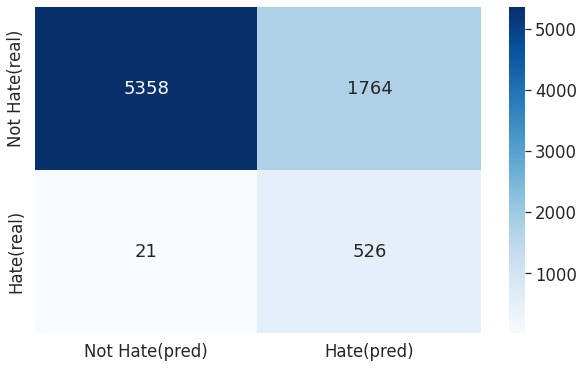

In [ ]:
plt.figure(figsize = (10,6))
confusion = confusion_matrix(true, pred, labels=[0,1])
sns.set(font_scale=1.5)
splot = sns.heatmap(confusion, 
                      annot=True, 
                      cmap='Blues', 
                      fmt='d', 
                      yticklabels = ['Not Hate(real)', 'Hate(real)'],
                      xticklabels = ['Not Hate(pred)', 'Hate(pred)'])
sfig = splot.get_figure()
sfig.savefig('./results/' + args.domain + '/to_' + args.test + '_new.png')